In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
x_train , x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
x_val = x_val.astype('float32')

In [5]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(x_val))
print(len(y_val))

40000
40000
10000
10000
10000
10000


In [6]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))

x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)


In [7]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)

In [8]:
weight_decay = 1e-4

In [9]:
from keras import models
from keras import layers

In [10]:
model = models.Sequential()

model.add(layers.Conv2D(6, (5,5), input_shape=(32,32,3), activation='tanh', strides=(1,1), padding='valid'))
model.add(layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(layers.Conv2D(16, (5,5), activation='tanh', strides=(1,1), padding='valid'))
model.add(layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(120, activation='tanh'))
model.add(layers.Dense(84, activation='tanh'))

model.add(layers.Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [12]:
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
mc = ModelCheckpoint('Ciphar_CNN_tanh.h5', monitor='val_loss', save_best_only=True)
tb = TensorBoard(log_dir='./logs', write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, update_freq='epoch')
cv = CSVLogger('Ciphar_CNN_tanh.csv',append=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
#es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [13]:
batch_size = 64

opt_rms = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True) 

model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=25,validation_data=(x_val,y_val),
                    class_weight='auto',verbose=1,callbacks=[LearningRateScheduler(lr_schedule),mc,cv,tb,rp])

Epoch 1/25
625/625 [==============================] - 16s 25ms/step - loss: 1.8174 - acc: 0.3535 - val_loss: 1.6481 - val_acc: 0.4146
Epoch 2/25
625/625 [==============================] - 15s 23ms/step - loss: 1.6532 - acc: 0.4148 - val_loss: 1.5571 - val_acc: 0.4531
Epoch 3/25
625/625 [==============================] - 15s 23ms/step - loss: 1.5458 - acc: 0.4508 - val_loss: 1.4491 - val_acc: 0.4861
Epoch 4/25
625/625 [==============================] - 15s 24ms/step - loss: 1.4803 - acc: 0.4722 - val_loss: 1.4062 - val_acc: 0.4996
Epoch 5/25
625/625 [==============================] - 14s 23ms/step - loss: 1.4357 - acc: 0.4891 - val_loss: 1.3791 - val_acc: 0.5061
Epoch 6/25
625/625 [==============================] - 14s 23ms/step - loss: 1.4070 - acc: 0.4967 - val_loss: 1.3408 - val_acc: 0.5226
Epoch 7/25
625/625 [==============================] - 15s 23ms/step - loss: 1.3768 - acc: 0.5070 - val_loss: 1.3160 - val_acc: 0.5344
Epoch 8/25
625/625 [==============================] - 15s 23ms

In [14]:
test_loss,test_acc=model.evaluate(x_test,y_test)
print(test_loss)
print(test_acc)

10000/10000 [==============================] - 1s 95us/step
1.1388251022338867
0.5948


In [17]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(25)

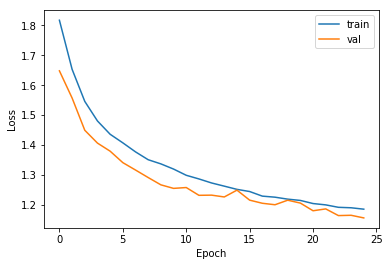

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

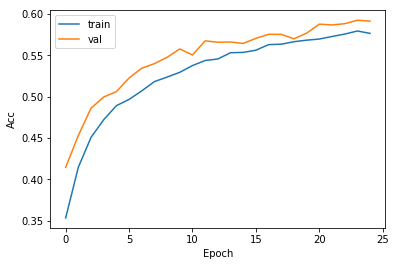

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [20]:
pred=model.predict(x_test[0].reshape(1,32,32,3))
print(pred)
print(pred.argmax())

[[0.01543544 0.01557327 0.04372528 0.2937038  0.13033834 0.41062596
  0.01283717 0.01836021 0.02168506 0.03771551]]
5


In [21]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.68      0.59      0.63      1000
     class 1       0.67      0.73      0.70      1000
     class 2       0.51      0.48      0.50      1000
     class 3       0.47      0.33      0.38      1000
     class 4       0.61      0.39      0.48      1000
     class 5       0.50      0.57      0.53      1000
     class 6       0.56      0.76      0.64      1000
     class 7       0.63      0.71      0.67      1000
     class 8       0.70      0.71      0.71      1000
     class 9       0.60      0.68      0.64      1000

   micro avg       0.59      0.59      0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



In [22]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc=np.trace(cm)/float(np.sum(cm))
    miss_class=1-acc
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(acc)
    print(miss_class)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[586  50  72  11  15   6  36  16 122  86]
 [ 25 733  10   6   1   8  27   9  30 151]
 [ 61  17 480  45  81  72 127  68  23  26]
 [ 17  19  80 326  45 260 136  56  25  36]
 [ 24   7 128  56 393  73 134 150  24  11]
 [  8   6  62 143  27 567  72  80  14  21]
 [  1  13  56  51  36  46 762  16   7  12]
 [ 20  13  18  40  33  85  29 713   8  41]
 [ 84  73  16  11   8  13  16  10 707  62]
 [ 31 156  14  12   3  11  27  22  43 681]]
0.5948
0.4052


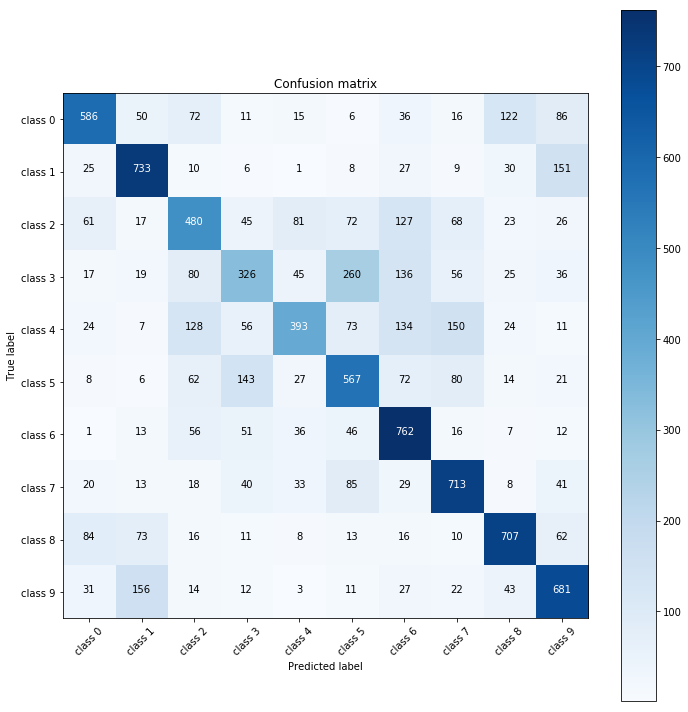

In [23]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')